## Test cases for 3D Nonlinear Schrodinger Equation

### Continuous Wave (CW) 3D NLSE

$$i\frac{\partial E}{\partial z} + \frac{1}{2k_0}\left(\frac{\partial^2 E}{\partial x^2} + \frac{\partial^2 E}{\partial y^2}\right) + \gamma|E|^2E = 0$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from src.util import plot_index_profile, plot_beam_intensity, plot_beam_intensity_and_phase, make_3d_animation, print_total_power, plot_3d_profile
from src.simulation import Domain, Fiber, KerrMedium, Input, run
from src.modes import calculate_modes, decompose_modes, n_to_lm, calculate_effective_mode_area

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Self-focusing

$\lambda = 1000 nm$

$n = 1.45$

$n_2 = 2.6e-20 m^2/W$

The critical power for self-focusing is

$P_{cr} = \frac{0.148 \lambda^2}{n n_2} \approx 4 MW$

In [3]:
wvl0 = 1000e-9
n = 1.45
n2 = 2.6e-20

P_cr = 0.148 * wvl0**2 / (n * n2)

Lx = 100e-6
Ly = 100e-6
Nx = 512
Ny = 512
dz = 1e-6
total_z = 1e-2

P_low = 0.95 * P_cr  # Initial power
P_high = 1.05 * P_cr  # High power for simulation
print(f'Critial power for self-focusing: {P_cr:.2f} W')

Critial power for self-focusing: 3925729.44 W


In [18]:
domain = Domain(Lx, Ly, Nx, Ny, total_z, device=device)
medium = KerrMedium(domain=domain, n0=n, n2=n2, device=device)
input_below_cr = Input(
    domain, wvl0, 0, 0, input_type='gaussian', beam_radius=10e-6, power=P_low, device=device)

input_above_cr = Input(
    domain, wvl0, 0, 0, input_type='gaussian', beam_radius=10e-6, power=P_high, device=device)

In [ ]:
input_field_below_cr = input_below_cr.field.cpu().numpy()
input_field_above_cr = input_above_cr.field.cpu().numpy()

plot_beam_intensity(input_field_below_cr,)

In [ ]:
fields_below_cr, energies, = run(domain, medium, input_below_cr, dz=dz,)
fields_below_cr = fields_below_cr.cpu().numpy()

In [ ]:
fields_above_cr, energies, = run(domain, medium, input_above_cr, dz=dz,)
fields_above_cr = fields_above_cr.cpu().numpy()

In [ ]:
intensities_below_cr = np.abs(fields_below_cr)**2
crosssection_below_cr = intensities_below_cr[:,:,intensities_below_cr.shape[2]//2]

intensities_above_cr = np.abs(fields_above_cr)**2
crosssection_above_cr = intensities_above_cr[:,:,intensities_above_cr.shape[2]//2]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# 첫 번째 서브플롯
im1 = ax1.imshow(crosssection_below_cr, cmap='turbo', aspect=5)
ax1.set_title('Below Critical')
plt.colorbar(im1, ax=ax1)

# 두 번째 서브플롯
im2 = ax2.imshow(crosssection_above_cr, cmap='turbo', aspect=5)
ax2.set_title('Above Critical')
plt.colorbar(im2, ax=ax2)

# 레이아웃 자동 조정
plt.tight_layout()

## 2. Self-imaging

$ w(z) = w_0 \sqrt{\cos^2{(\pi z/ z_p)} + C^2 \sin^2{(\pi z / z_p)}} $

where $z_p = \frac{\pi a}{\sqrt{2 \Delta}}$, $C = \frac{z_p / \beta}{\pi w_0^2}$

In [3]:
wvl0 = 775e-9
n0 = 1.45
NA = 0.25
nc = np.sqrt(n0**2 + NA**2)

n2 = 2.6e-20


diameter = 50e-6
radius = diameter / 2

Lx = 50e-6
Ly = 50e-6
Nx = 512
Ny = 512
dz = 1e-5
total_z = 1.0

P0 = 1e3

In [8]:
beam_radius = 10e-6

domain = Domain(Lx, Ly, Nx, Ny, total_z, device=device)
medium = Fiber(domain=domain, nc=nc, n0=n0, n2=n2, device=device)
input_beam = Input(
    domain, wvl0, 0, 0, input_type='gaussian', beam_radius=beam_radius, power=P0, device=device)

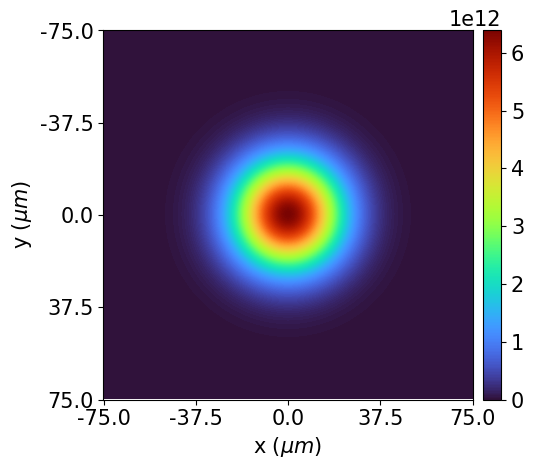

In [11]:
input_field = input_beam.field.cpu().numpy()
plot_beam_intensity(input_field, interpolation="bilinear")

In [ ]:
fields, energies, = run(domain, medium, input_beam, dz=dz,)

Simulating propagation: 100%|██████████| 99999/99999 [00:23<00:00, 4324.34it/s]


In [ ]:
# Subplot 3D
fig = plt.subplots(figsize=(10, 8))
plot_3d_profile(fields, title='3D Profile of the Beam', cmap='turbo')

#### Self-imaging of GRIN rod

In [ ]:
# On-axis

# Off-axis


## 3. Kerr Beam Self-cleaning in GRIN MMF

Reprouction of Krupa et al., Kerr beam self-cleaning


In [3]:
wvl0 = 1060e-9
nc = 1.47
n0 = 1.457
n2 = 3.2e-20
fiber_radius = 26e-6

Lx = 150e-6
Ly = 150e-6
Nx = 512
Ny = 512
dz = 5e-6
total_z = 2.0 

P_low = 6.3
P_middle = 10e3
P_high = 20e3

In [ ]:
precision = 'double'
domain = Domain(Lx, Ly, Nx, Ny, total_z, precision=precision, device=device)
medium = Fiber(domain=domain, nc=nc, n0=n0, n2=n2, radius=fiber_radius, precision=precision, device=device)
input_beam_low = Input(
    domain, wvl0, nc, n0, input_type='mode', num_modes=10, fiber_radius=fiber_radius, power=P_low, precision=precision, device=device)
input_beam_middle = Input(
    domain, wvl0, nc, n0, input_type='mode', num_modes=10, fiber_radius=fiber_radius, power=P_middle, precision=precision, device=device)
input_beam_high = Input(
    domain, wvl0, nc, n0, input_type='mode', num_modes=10, fiber_radius=fiber_radius, power=P_high, precision=precision, device=device)

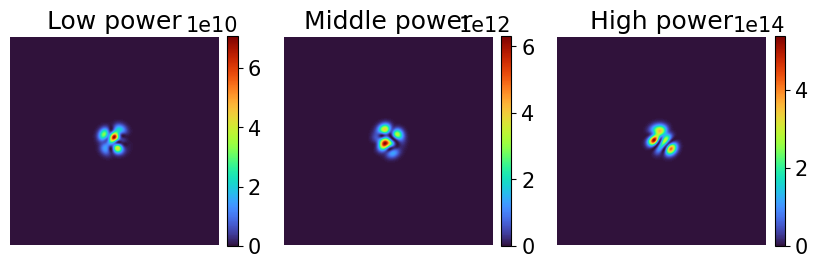

In [40]:
input_field_low = input_beam_low.field.cpu().numpy()
intensity_low = np.abs(input_field_low)**2

input_field_middle = input_beam_middle.field.cpu().numpy()
intensity_middle = np.abs(input_field_middle)**2

input_field_high = input_beam_high.field.cpu().numpy()
intensity_high = np.abs(input_field_high)**2

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(intensity_low, cmap='turbo')
axes[0].set_title('Low power')
axes[0].axis('off')
# show colorbar
plt.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

axes[1].imshow(intensity_middle, cmap='turbo')
axes[1].set_title('Middle power')
axes[1].axis('off')
plt.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046, pad=0.04)

axes[2].imshow(intensity_high, cmap='turbo')
axes[2].set_title('High power')
axes[2].axis('off')
plt.colorbar(axes[2].images[0], ax=axes[2], fraction=0.046, pad=0.04)

# plot_beam_intensity(intensity_low,)


In [41]:
dz=1e-6
fields_low, _, modes_low = run(domain, medium, input_beam_low, dz=dz, precision=precision, trace_modes=True)
fields_middle, _, modes_middle = run(domain, medium, input_beam_middle, dz=dz, precision=precision, trace_modes=True)
fields_high, _, modes_high = run(domain, medium, input_beam_high, dz=dz, precision=precision, trace_modes=True)

Simulating propagation: 100%|██████████| 2000000/2000000 [15:10<00:00, 2196.34it/s]


In [42]:
dz=1e-5
fields_low_2, _, modes_low_2 = run(domain, medium, input_beam_low, dz=dz, precision=precision, trace_modes=True)
fields_middle_2, _, modes_middle_2 = run(domain, medium, input_beam_middle, dz=dz, precision=precision, trace_modes=True)
fields_high_2, _, modes_high_2 = run(domain, medium, input_beam_high, dz=dz, precision=precision, trace_modes=True)

Simulating propagation: 100%|██████████| 199999/199999 [01:33<00:00, 2145.08it/s]


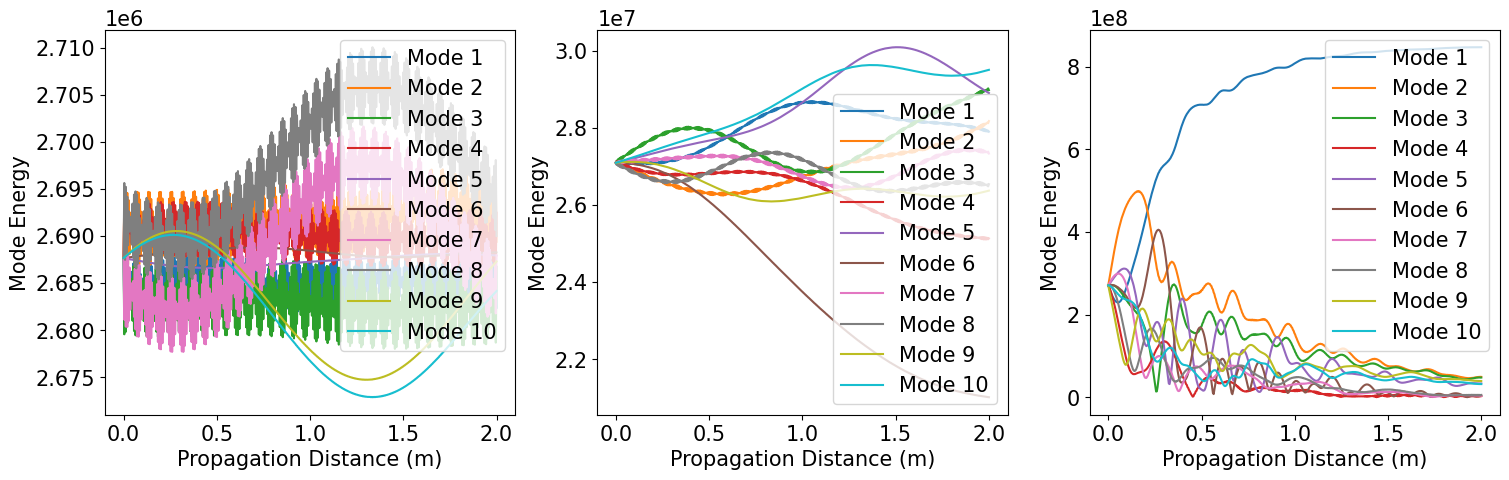

In [45]:
#dz = 1e-5, double precision
z = np.linspace(0, total_z, modes_low_2.shape[0])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i in range(10):
    axes[0].plot(z, modes_low_2[:,i], label=f'Mode {i+1}')

# plt.ylim(0, 1.0)
axes[0].set_xlabel('Propagation Distance (m)')
axes[0].set_ylabel('Mode Energy')
axes[0].legend()

for i in range(10):
    axes[1].plot(z, modes_middle_2[:,i], label=f'Mode {i+1}')

# plt.ylim(0, 1.0)
axes[1].set_xlabel('Propagation Distance (m)')
axes[1].set_ylabel('Mode Energy')
axes[1].legend()

for i in range(10):
    axes[2].plot(z, modes_high_2[:,i], label=f'Mode {i+1}')

# plt.ylim(0, 1.0)
axes[2].set_xlabel('Propagation Distance (m)')
axes[2].set_ylabel('Mode Energy')
axes[2].legend()


In [44]:
if type(fields_low) is torch.Tensor:
    fields_low = fields_low.cpu().numpy()
make_3d_animation(fields_low, radius=fiber_radius, propagation_length=total_z*100, filename='./results/grin_low', interpolation="bilinear")

if type(fields_middle) is torch.Tensor:
    fields_middle = fields_middle.cpu().numpy()
make_3d_animation(fields_middle, radius=fiber_radius, propagation_length=total_z*100, filename='./results/grin_middle', interpolation="bilinear")

if type(fields_high) is torch.Tensor:
    fields_high = fields_high.cpu().numpy()
make_3d_animation(fields_high, radius=fiber_radius, propagation_length=total_z*100, filename='./results/grin_high', interpolation="bilinear")


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## 4. Input mode condition

First 20 modes

In [ ]:
# Mode profile for first 20 modes

In [8]:
coefficients1 = np.array([9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
coefficients2 = np.array([7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0])
coefficients3 = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

coefficient1 = np.sqrt(coefficients1)
coefficient2 = np.sqrt(coefficients2)
coefficient3 = np.sqrt(coefficients3)
 

In [77]:
P_middle = 30e3
P_high = 40e3

domain = Domain(Lx, Ly, Nx, Ny, total_z, precision=precision, device=device)
medium = Fiber(domain=domain, nc=nc, n0=n0, n2=n2, radius=fiber_radius, precision=precision, device=device)
input_beam_middle1 = Input(
    domain, wvl0, nc, n0, input_type='mode', num_modes=20, coefficients=coefficients1, fiber_radius=fiber_radius, power=P_middle, precision=precision, device=device)
input_beam_middle2 = Input(
    domain, wvl0, nc, n0, input_type='mode', num_modes=20, coefficients=coefficients2, fiber_radius=fiber_radius, power=P_middle, precision=precision, device=device)
input_beam_middle3 = Input(
    domain, wvl0, nc, n0, input_type='mode', num_modes=20, coefficients=coefficients3, fiber_radius=fiber_radius, power=P_middle, precision=precision, device=device)

input_beam_high1 = Input(
    domain, wvl0, nc, n0, input_type='mode', num_modes=20, coefficients=coefficient1, fiber_radius=fiber_radius, power=P_high, precision=precision, device=device)
input_beam_high2 = Input(
    domain, wvl0, nc, n0, input_type='mode', num_modes=20, coefficients=coefficient2, fiber_radius=fiber_radius, power=P_high, precision=precision, device=device)
input_beam_high3 = Input(
    domain, wvl0, nc, n0, input_type='mode', num_modes=20, coefficients=coefficient3, fiber_radius=fiber_radius, power=P_high, precision=precision, device=device)

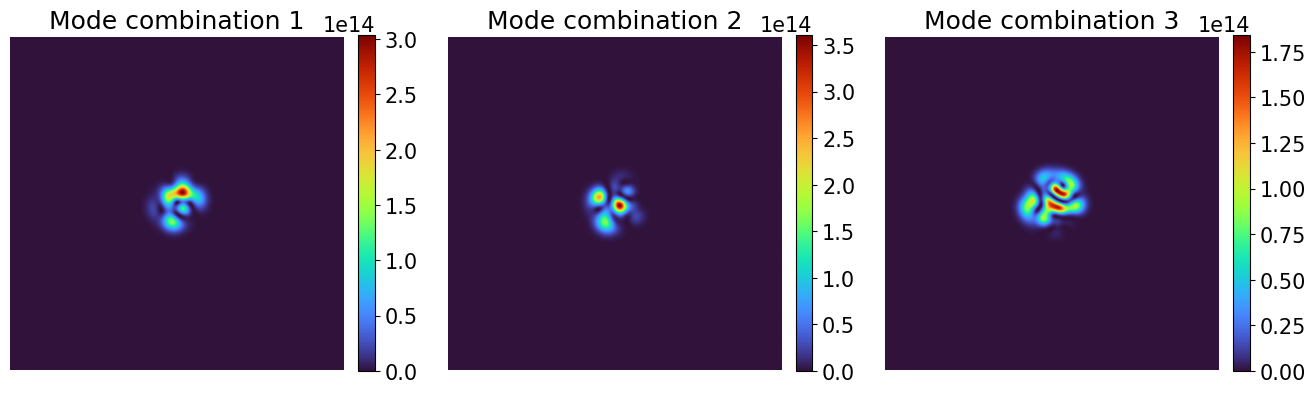

In [78]:
input_field_middle1 = input_beam_middle1.field.cpu().numpy()
intensity_middle1 = np.abs(input_field_middle1)**2
input_field_middle2 = input_beam_middle2.field.cpu().numpy()
intensity_middle2 = np.abs(input_field_middle2)**2
input_field_middle3 = input_beam_middle3.field.cpu().numpy()
intensity_middle3 = np.abs(input_field_middle3)**2

input_field_high1 = input_beam_high1.field.cpu().numpy()
intensity_high1 = np.abs(input_field_high1)**2
input_field_high2 = input_beam_high2.field.cpu().numpy()
intensity_high2 = np.abs(input_field_high2)**2
input_field_high3 = input_beam_high3.field.cpu().numpy()
intensity_high3 = np.abs(input_field_high3)**2

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(intensity_middle1, cmap='turbo')
axes[0].set_title('Mode combination 1')
axes[0].axis('off')
# show colorbar
plt.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

axes[1].imshow(intensity_middle2, cmap='turbo')
axes[1].set_title('Mode combination 2')
axes[1].axis('off')
plt.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046, pad=0.04)

axes[2].imshow(intensity_middle3, cmap='turbo')
axes[2].set_title('Mode combination 3')
axes[2].axis('off')
plt.colorbar(axes[2].images[0], ax=axes[2], fraction=0.046, pad=0.04)

# plot_beam_intensity(intensity_low,)


In [79]:
dz = 1e-5
precision = 'double'
fields_middle1, _, modes_middle1 = run(domain, medium, input_beam_middle1, dz=dz, precision=precision, trace_modes=True)
fields_middle2, _, modes_middle2 = run(domain, medium, input_beam_middle2, dz=dz, precision=precision, trace_modes=True)
fields_middle3, _, modes_middle3 = run(domain, medium, input_beam_middle3, dz=dz, precision=precision, trace_modes=True)
fields_high1, _, modes_high1 = run(domain, medium, input_beam_high1, dz=dz, precision=precision, trace_modes=True)
fields_high2, _, modes_high2 = run(domain, medium, input_beam_high2, dz=dz, precision=precision, trace_modes=True)
fields_high3, _, modes_high3 = run(domain, medium, input_beam_high3, dz=dz, precision=precision, trace_modes=True)

Simulating propagation: 100%|██████████| 199999/199999 [01:32<00:00, 2159.86it/s]


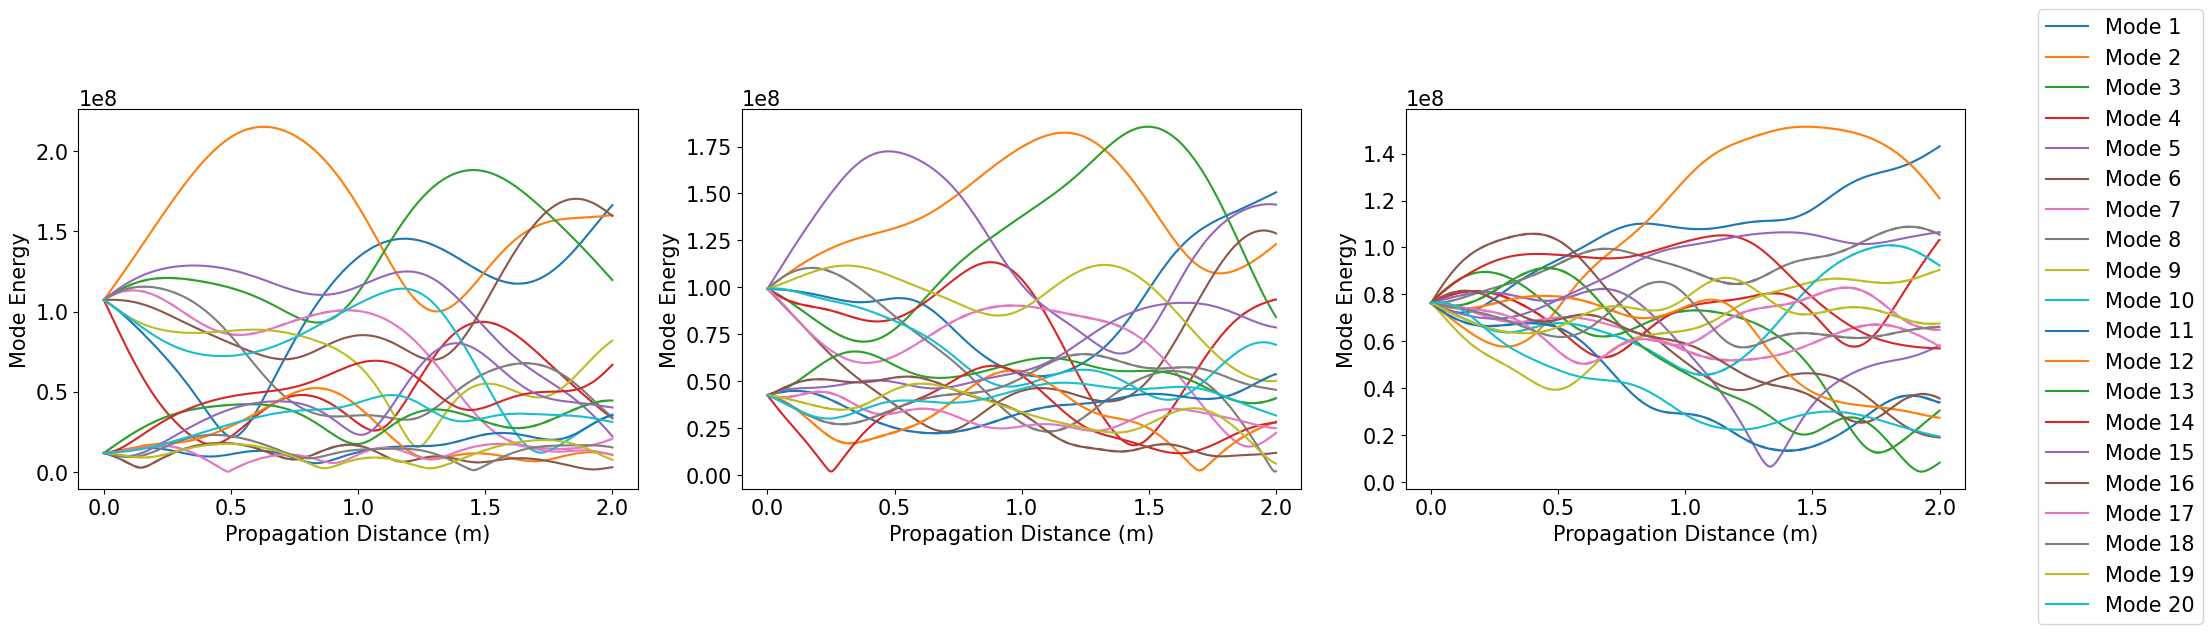

In [ ]:
z = np.linspace(0, total_z, modes_middle1.shape[0])
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i in range(20):
    axes[0].plot(z, modes_middle1[:,i], label=f'Mode {i+1}')
axes[0].set_xlabel('Propagation Distance (m)')
axes[0].set_ylabel('Mode Energy')

for i in range(20):
    axes[1].plot(z, modes_middle2[:,i], label=f'Mode {i+1}')
axes[1].set_xlabel('Propagation Distance (m)')
axes[1].set_ylabel('Mode Energy')

for i in range(20):
    axes[2].plot(z, modes_middle3[:,i], label=f'Mode {i+1}')
axes[2].set_xlabel('Propagation Distance (m)')
axes[2].set_ylabel('Mode Energy')

# 마지막 subplot에서 handles와 labels 가져와서 figure 범례 생성
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.show()

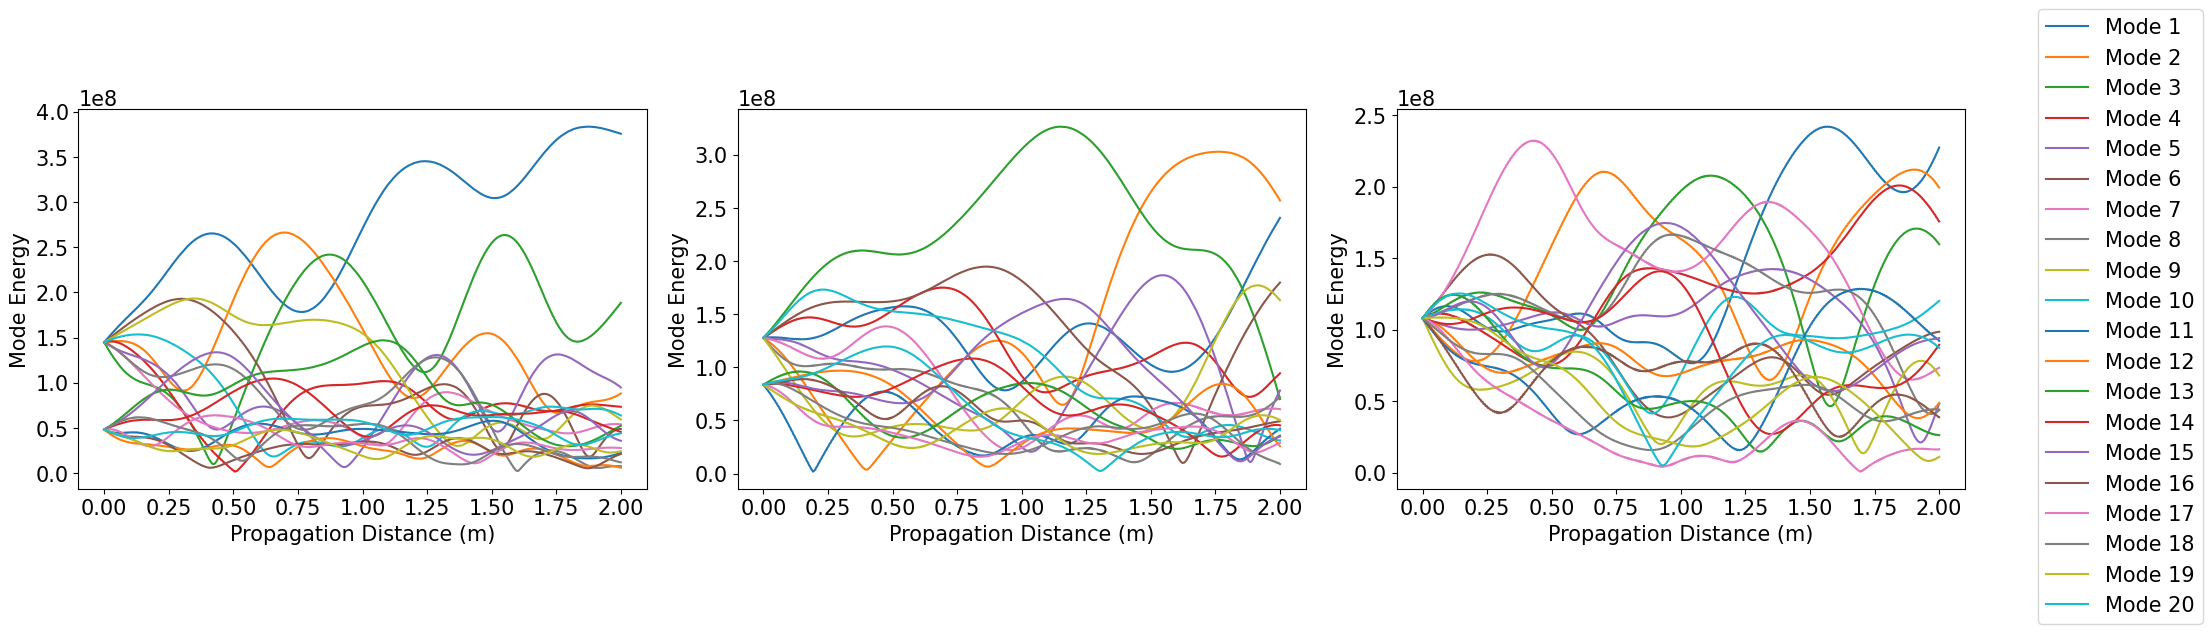

In [74]:
z = np.linspace(0, total_z, modes_high1.shape[0])
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i in range(20):
    axes[0].plot(z, modes_high1[:,i], label=f'Mode {i+1}')
axes[0].set_xlabel('Propagation Distance (m)')
axes[0].set_ylabel('Mode Energy')

for i in range(20):
    axes[1].plot(z, modes_high2[:,i], label=f'Mode {i+1}')
axes[1].set_xlabel('Propagation Distance (m)')
axes[1].set_ylabel('Mode Energy')

for i in range(20):
    axes[2].plot(z, modes_high3[:,i], label=f'Mode {i+1}')
axes[2].set_xlabel('Propagation Distance (m)')
axes[2].set_ylabel('Mode Energy')

# 마지막 subplot에서 handles와 labels 가져와서 figure 범례 생성
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.show()

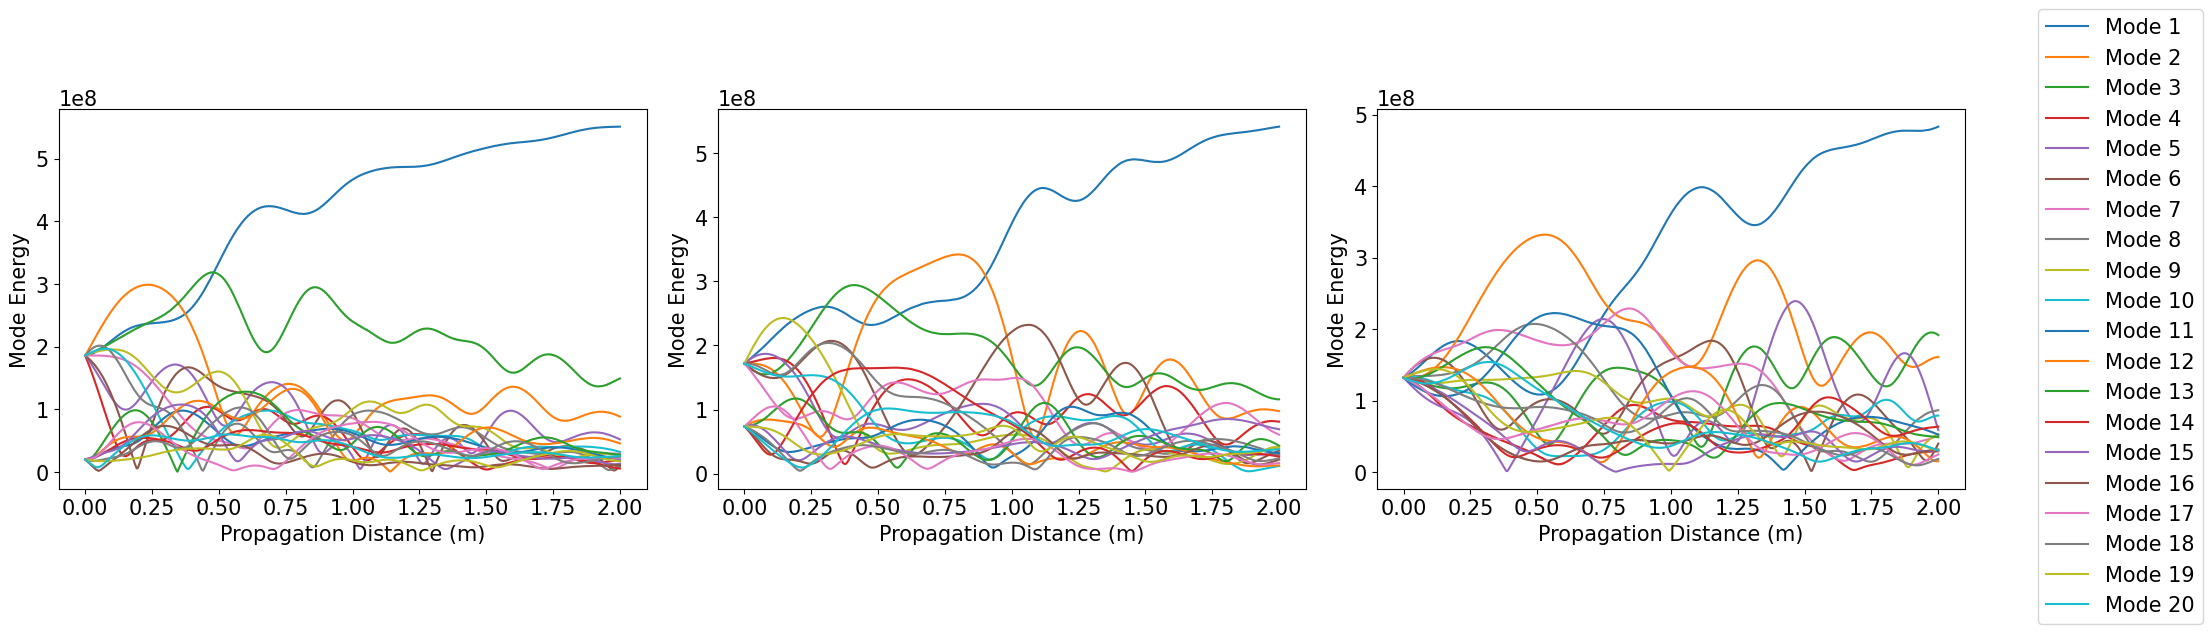

In [80]:
z = np.linspace(0, total_z, modes_middle1.shape[0])
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i in range(20):
    axes[0].plot(z, modes_middle1[:,i], label=f'Mode {i+1}')
axes[0].set_xlabel('Propagation Distance (m)')
axes[0].set_ylabel('Mode Energy')

for i in range(20):
    axes[1].plot(z, modes_middle2[:,i], label=f'Mode {i+1}')
axes[1].set_xlabel('Propagation Distance (m)')
axes[1].set_ylabel('Mode Energy')

for i in range(20):
    axes[2].plot(z, modes_middle3[:,i], label=f'Mode {i+1}')
axes[2].set_xlabel('Propagation Distance (m)')
axes[2].set_ylabel('Mode Energy')

# 마지막 subplot에서 handles와 labels 가져와서 figure 범례 생성
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.show()

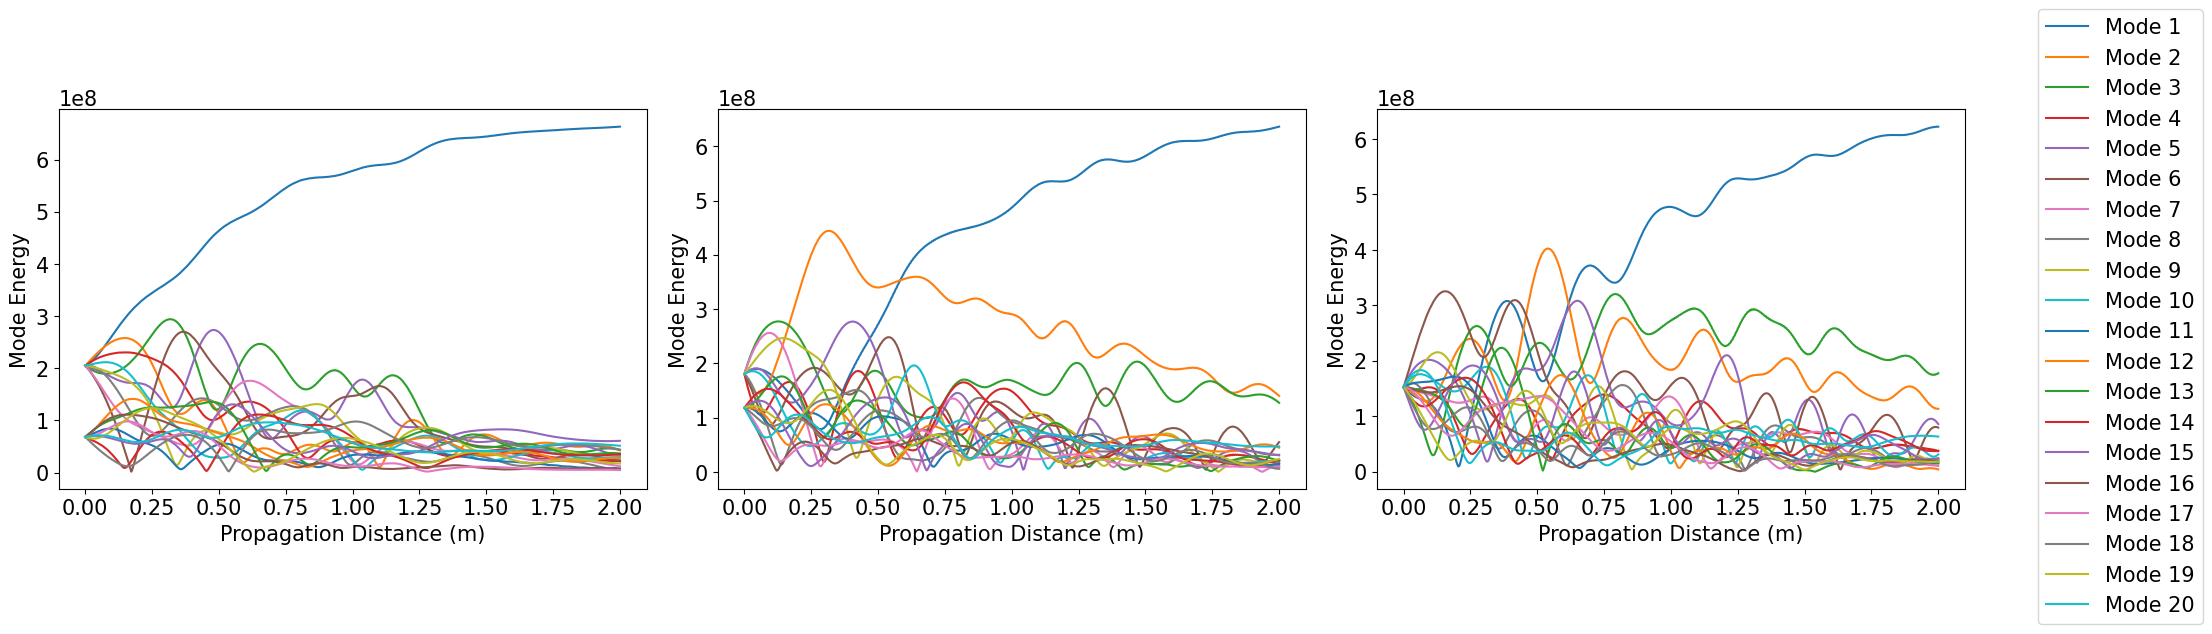

In [81]:
z = np.linspace(0, total_z, modes_high1.shape[0])
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i in range(20):
    axes[0].plot(z, modes_high1[:,i], label=f'Mode {i+1}')
axes[0].set_xlabel('Propagation Distance (m)')
axes[0].set_ylabel('Mode Energy')

for i in range(20):
    axes[1].plot(z, modes_high2[:,i], label=f'Mode {i+1}')
axes[1].set_xlabel('Propagation Distance (m)')
axes[1].set_ylabel('Mode Energy')

for i in range(20):
    axes[2].plot(z, modes_high3[:,i], label=f'Mode {i+1}')
axes[2].set_xlabel('Propagation Distance (m)')
axes[2].set_ylabel('Mode Energy')

# 마지막 subplot에서 handles와 labels 가져와서 figure 범례 생성
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.show()

In [83]:
if type(fields_middle1) is torch.Tensor:
    fields_middle1 = fields_middle1.cpu().numpy()
make_3d_animation(fields_middle1, radius=fiber_radius, propagation_length=total_z*100, filename='./results/grin_modes_1_30kW', interpolation="bilinear")

if type(fields_middle2) is torch.Tensor:
    fields_middle2 = fields_middle2.cpu().numpy()
make_3d_animation(fields_middle2, radius=fiber_radius, propagation_length=total_z*100, filename='./results/grin_modes_2_30kW', interpolation="bilinear")

if type(fields_middle3) is torch.Tensor:
    fields_middle3 = fields_middle3.cpu().numpy()
make_3d_animation(fields_middle3, radius=fiber_radius, propagation_length=total_z*100, filename='./results/grin_modes_3_30kW', interpolation="bilinear")


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
if type(fields_high1) is torch.Tensor:
    fields_high1 = fields_high1.cpu().numpy()
make_3d_animation(fields_high1, radius=fiber_radius, propagation_length=total_z*100, filename='./results/grin_modes_1_40kW', interpolation="bilinear")

if type(fields_high2) is torch.Tensor:
    fields_high2 = fields_high2.cpu().numpy()
make_3d_animation(fields_high2, radius=fiber_radius, propagation_length=total_z*100, filename='./results/grin_modes_2_40kW', interpolation="bilinear")

if type(fields_high3) is torch.Tensor:
    fields_high3 = fields_high3.cpu().numpy()
make_3d_animation(fields_high3, radius=fiber_radius, propagation_length=total_z*100, filename='./results/grin_modes_3_40kW', interpolation="bilinear")


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## 5. Scaling of fiber size

In [9]:
precision = 'double'
domain_1 = Domain(Lx, Ly, Nx, Ny, total_z, precision=precision, device=device)
domain_2 = Domain(Lx*2, Ly*2, Nx*2, Ny*2, total_z, precision=precision, device=device)
domain_3 = Domain(Lx*4, Ly*4, Nx*4, Ny*4, total_z, precision=precision, device=device)

fiber_radius_1 = 25e-6
fiber_radius_2 = 50e-6
fiber_radius_3 = 100e-6

medium_1 = Fiber(domain=domain_1, nc=nc, n0=n0, n2=n2, radius=fiber_radius_1, precision=precision, device=device)
medium_2 = Fiber(domain=domain_2, nc=nc, n0=n0, n2=n2, radius=fiber_radius_2, precision=precision, device=device)
medium_3 = Fiber(domain=domain_3, nc=nc, n0=n0, n2=n2, radius=fiber_radius_3, precision=precision, device=device)

input_beam_middle1 = Input(
    domain_1, wvl0, nc, n0, input_type='mode', num_modes=20, fiber_radius=fiber_radius_1, coefficients=coefficient1, power=P_middle, precision=precision, device=device)
input_beam_middle2 = Input(
    domain_2, wvl0, nc, n0, input_type='mode', num_modes=20, fiber_radius=fiber_radius_2, coefficients=coefficient1, power=P_middle, precision=precision, device=device)
input_beam_middle3 = Input(
    domain_3, wvl0, nc, n0, input_type='mode', num_modes=20, fiber_radius=fiber_radius_3, coefficients=coefficient1, power=P_middle, precision=precision, device=device)
input_beam_high1 = Input(
    domain_1, wvl0, nc, n0, input_type='mode', num_modes=20, fiber_radius=fiber_radius_1, coefficients=coefficient1, power=P_high, precision=precision, device=device)
input_beam_high2 = Input(
    domain_2, wvl0, nc, n0, input_type='mode', num_modes=20, fiber_radius=fiber_radius_2, coefficients=coefficient1, power=P_high, precision=precision, device=device)
input_beam_high3 = Input(
    domain_3, wvl0, nc, n0, input_type='mode', num_modes=20, fiber_radius=fiber_radius_3, coefficients=coefficient1, power=P_high, precision=precision, device=device)

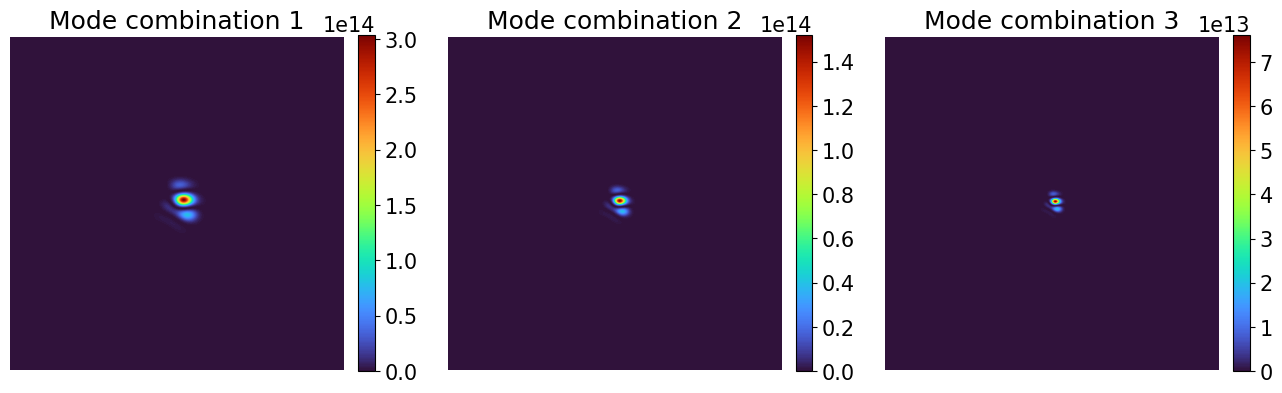

In [11]:
input_field_middle1 = input_beam_middle1.field.cpu().numpy()
intensity_middle1 = np.abs(input_field_middle1)**2
input_field_middle2 = input_beam_middle2.field.cpu().numpy()
intensity_middle2 = np.abs(input_field_middle2)**2
input_field_middle3 = input_beam_middle3.field.cpu().numpy()
intensity_middle3 = np.abs(input_field_middle3)**2

input_field_high1 = input_beam_high1.field.cpu().numpy()
intensity_high1 = np.abs(input_field_high1)**2
input_field_high2 = input_beam_high2.field.cpu().numpy()
intensity_high2 = np.abs(input_field_high2)**2
input_field_high3 = input_beam_high3.field.cpu().numpy()
intensity_high3 = np.abs(input_field_high3)**2

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(intensity_middle1, cmap='turbo')
axes[0].set_title('Mode combination 1')
axes[0].axis('off')
# show colorbar
plt.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

axes[1].imshow(intensity_middle2, cmap='turbo')
axes[1].set_title('Mode combination 2')
axes[1].axis('off')
plt.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046, pad=0.04)

axes[2].imshow(intensity_middle3, cmap='turbo')
axes[2].set_title('Mode combination 3')
axes[2].axis('off')
plt.colorbar(axes[2].images[0], ax=axes[2], fraction=0.046, pad=0.04)

# plot_beam_intensity(intensity_low,)


In [13]:
dz = 1e-5
precision = 'double'
fields_middle1, _, modes_middle1 = run(domain_1, medium_1, input_beam_middle1, dz=dz, precision=precision, trace_modes=True)
fields_middle2, _, modes_middle2 = run(domain_2, medium_2, input_beam_middle2, dz=dz, precision=precision, trace_modes=True)
fields_middle3, _, modes_middle3 = run(domain_3, medium_3, input_beam_middle3, dz=dz, precision=precision, trace_modes=True)
fields_high1, _, modes_high1 = run(domain_1, medium_1, input_beam_high1, dz=dz, precision=precision, trace_modes=True)
fields_high2, _, modes_high2 = run(domain_2, medium_2, input_beam_high2, dz=dz, precision=precision, trace_modes=True)
fields_high3, _, modes_high3 = run(domain_3, medium_3, input_beam_high3, dz=dz, precision=precision, trace_modes=True)

Simulating propagation: 100%|██████████| 199999/199999 [23:42<00:00, 140.58it/s]


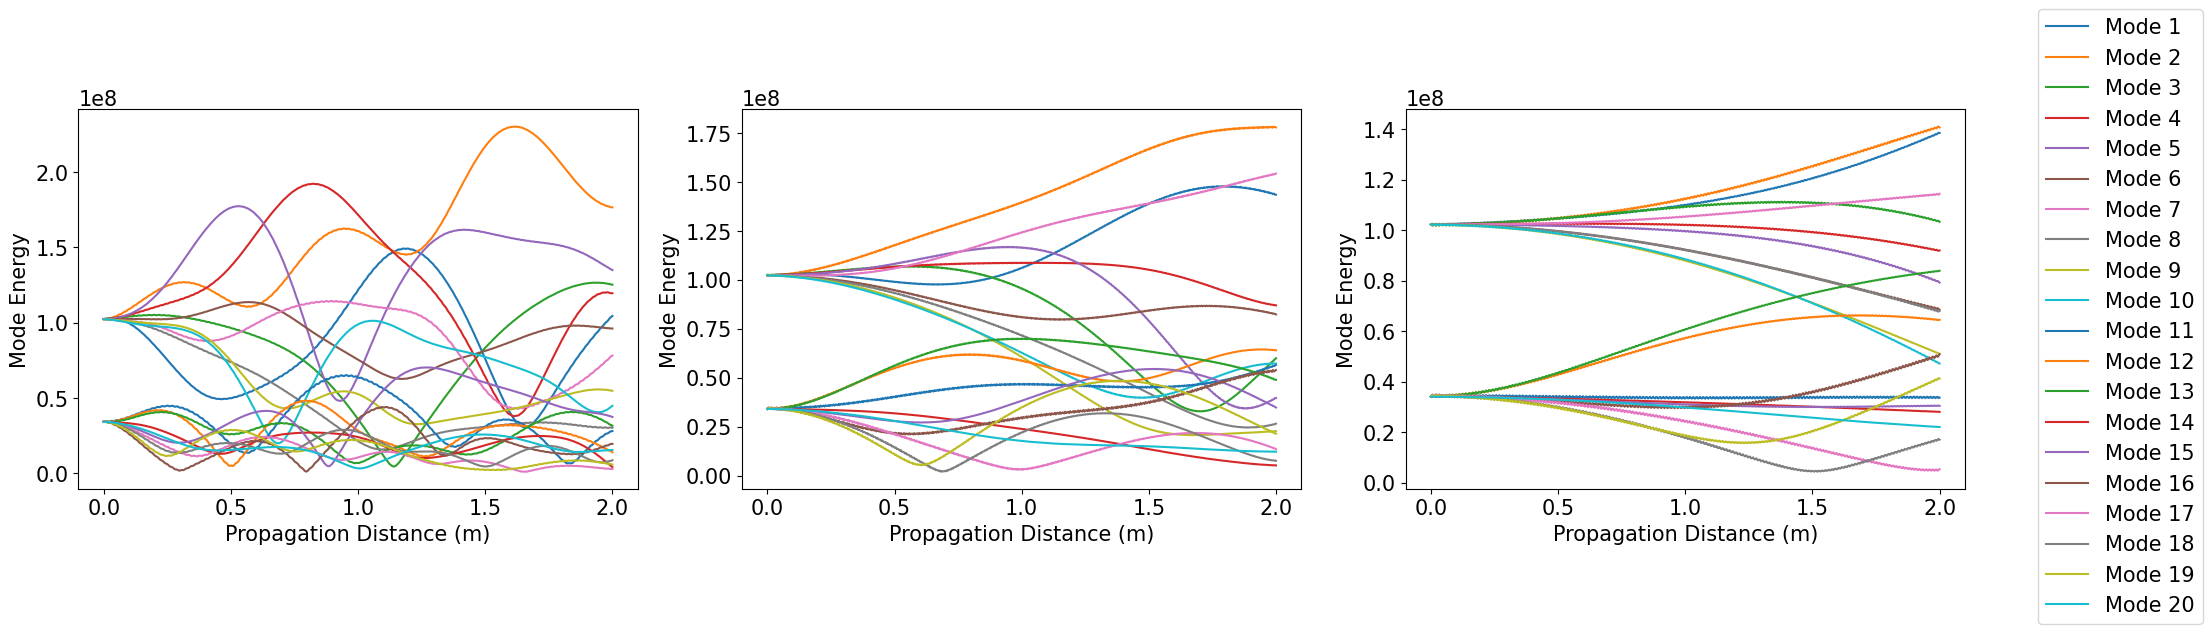

In [14]:
z = np.linspace(0, total_z, modes_middle1.shape[0])
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i in range(20):
    axes[0].plot(z, modes_middle1[:,i], label=f'Mode {i+1}')
axes[0].set_xlabel('Propagation Distance (m)')
axes[0].set_ylabel('Mode Energy')

for i in range(20):
    axes[1].plot(z, modes_middle2[:,i], label=f'Mode {i+1}')
axes[1].set_xlabel('Propagation Distance (m)')
axes[1].set_ylabel('Mode Energy')

for i in range(20):
    axes[2].plot(z, modes_middle3[:,i], label=f'Mode {i+1}')
axes[2].set_xlabel('Propagation Distance (m)')
axes[2].set_ylabel('Mode Energy')

# 마지막 subplot에서 handles와 labels 가져와서 figure 범례 생성
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.show()

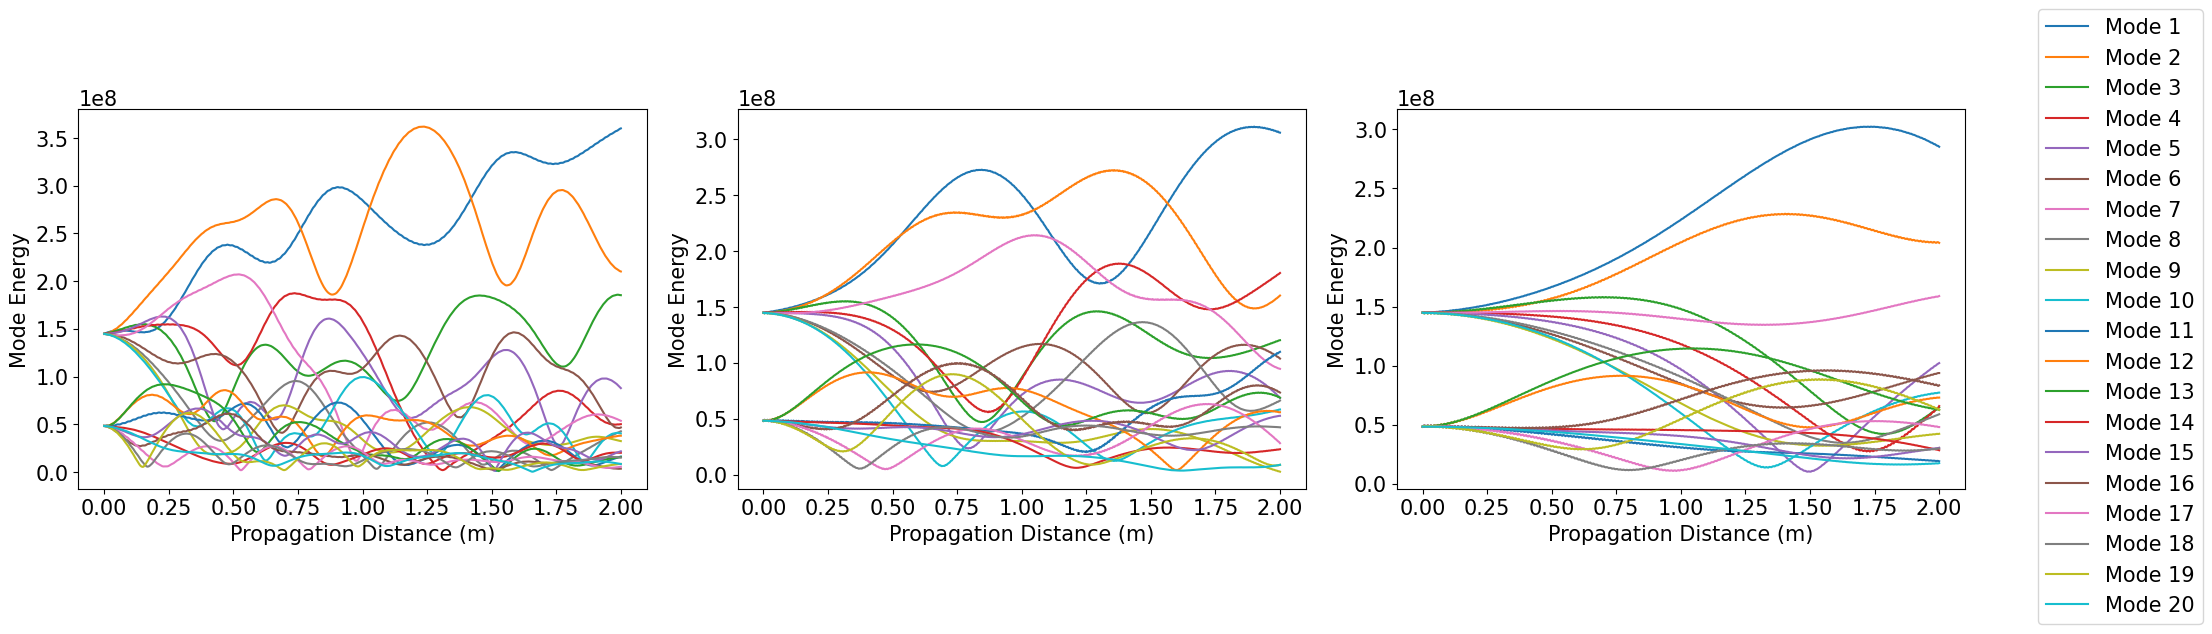

In [15]:
z = np.linspace(0, total_z, modes_high1.shape[0])
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i in range(20):
    axes[0].plot(z, modes_high1[:,i], label=f'Mode {i+1}')
axes[0].set_xlabel('Propagation Distance (m)')
axes[0].set_ylabel('Mode Energy')

for i in range(20):
    axes[1].plot(z, modes_high2[:,i], label=f'Mode {i+1}')
axes[1].set_xlabel('Propagation Distance (m)')
axes[1].set_ylabel('Mode Energy')

for i in range(20):
    axes[2].plot(z, modes_high3[:,i], label=f'Mode {i+1}')
axes[2].set_xlabel('Propagation Distance (m)')
axes[2].set_ylabel('Mode Energy')

# 마지막 subplot에서 handles와 labels 가져와서 figure 범례 생성
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.show()

In [18]:
if type(fields_middle1) is torch.Tensor:
    fields_middle1 = fields_middle1.cpu().numpy()
make_3d_animation(fields_middle1, radius=fiber_radius, propagation_length=total_z*100, filename='./results/grin_modes_30kW_small', interpolation="bilinear")

if type(fields_middle2) is torch.Tensor:
    fields_middle2 = fields_middle2.cpu().numpy()
make_3d_animation(fields_middle2, radius=fiber_radius, propagation_length=total_z*100, filename='./results/grin_modes_30kW_middle', interpolation="bilinear")

if type(fields_middle3) is torch.Tensor:
    fields_middle3 = fields_middle3.cpu().numpy()
make_3d_animation(fields_middle3, radius=fiber_radius, propagation_length=total_z*100, filename='./results/grin_modes_30kW_large', interpolation="bilinear")


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
if type(fields_high1) is torch.Tensor:
    fields_high1 = fields_high1.cpu().numpy()
make_3d_animation(fields_high1, radius=fiber_radius, propagation_length=total_z*100, filename='./results/grin_modes_40kW_small', interpolation="bilinear")

if type(fields_high2) is torch.Tensor:
    fields_high2 = fields_high2.cpu().numpy()
make_3d_animation(fields_high2, radius=fiber_radius, propagation_length=total_z*100, filename='./results/grin_modes_40kW_middle', interpolation="bilinear")

if type(fields_high3) is torch.Tensor:
    fields_high3 = fields_high3.cpu().numpy()
make_3d_animation(fields_high3, radius=fiber_radius, propagation_length=total_z*100, filename='./results/grin_modes_40kW_large', interpolation="bilinear")


## 6. Nonlinear phase shifts

B integral

$\phi_{NL} = \frac{2 \pi}{k_0} \frac{n_2 P}{A_{eff}} $

## 7. Add time dependence : Spectral broadening

$$\frac{\partial E}{\partial z} = \frac{i}{2k_0}\left(\frac{\partial^2 E}{\partial x^2} + \frac{\partial^2 E}{\partial y^2}\right) + i\gamma|E|^2E - i \frac{\beta_2}{2} \frac{\partial^2 E}{\partial t^2}$$
